In [2]:
#hide
import fastbook
from fastbook import *
from fastai.vision.widgets import *

/Users/abhgpta/miniconda3/lib/python3.12/site-packages/fastbook/__init__.py:13: UserWarning: Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`
  except ModuleNotFoundError: warn("Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`")


In [3]:
ims = search_images_ddg('grizzly bear')
len(ims)

200

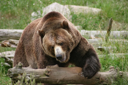

In [4]:
# Quick sanity check
dest = 'images/grizzly.jpg'
download_url(ims[1], dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(128, 128)

In [5]:
bear_types = 'grizzly', 'black', 'teddy'
path = Path('bears')
if not path.exists():
    path.mkdir()
    for b in bear_types:
        dest = path/b
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{b} bear')
        download_images(dest, urls=results)

In [6]:
# Remove bad images
fns = get_image_files(path)
failed = verify_images(fns)
failed.map(Path.unlink)


(#0) []

In [7]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [8]:
dls = bears.dataloaders(path)

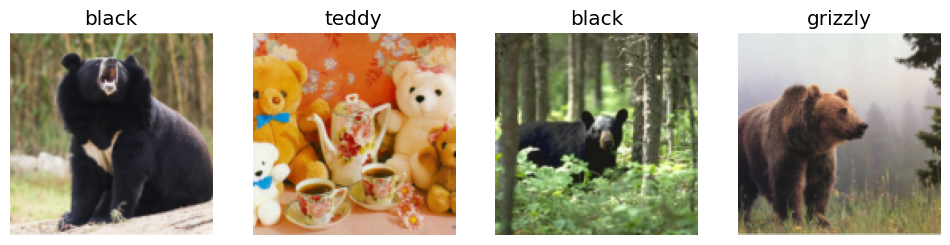

In [9]:
dls.valid.show_batch(max_n=4, nrows=1)

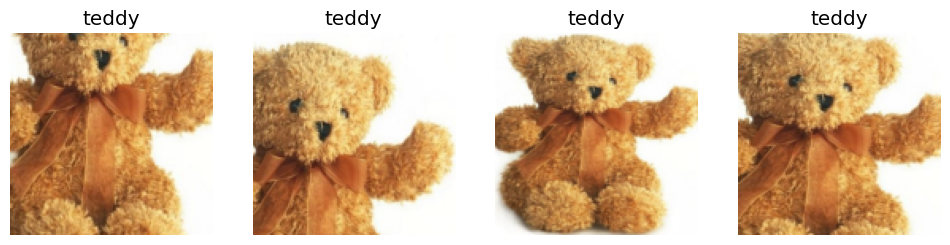

In [10]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

/Users/abhgpta/miniconda3/lib/python3.12/site-packages/torch/_tensor.py:1386: UserWarning: The operator 'aten::_linalg_solve_ex.result' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1707398034107/work/aten/src/ATen/mps/MPSFallback.mm:13.)
  ret = func(*args, **kwargs)


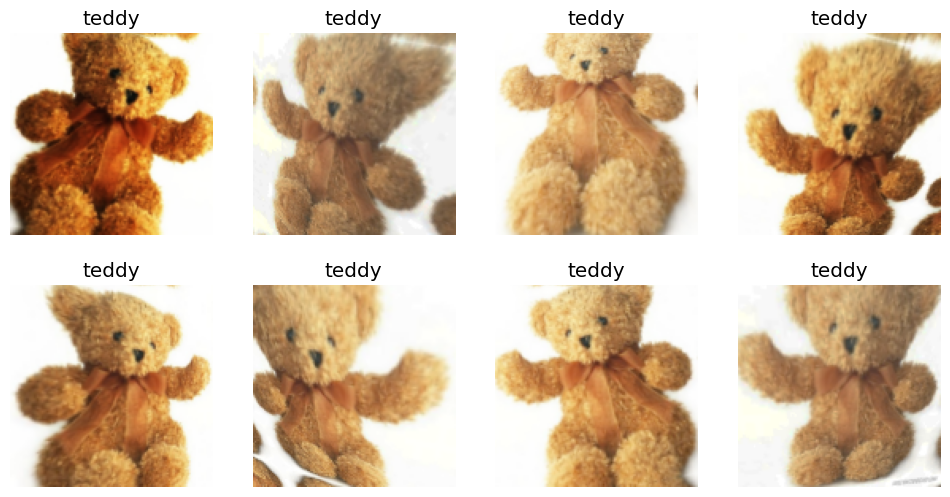

In [11]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [12]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/abhgpta/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 23.1MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.470382,0.088226,0.055046,00:18


epoch,train_loss,valid_loss,error_rate,time
0,0.255348,0.068389,0.027523,00:14
1,0.188246,0.051791,0.018349,00:13
2,0.166444,0.049283,0.009174,00:13
3,0.150150,0.045531,0.018349,00:13


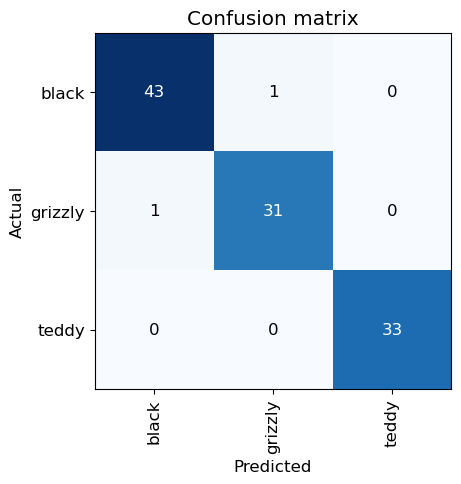

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

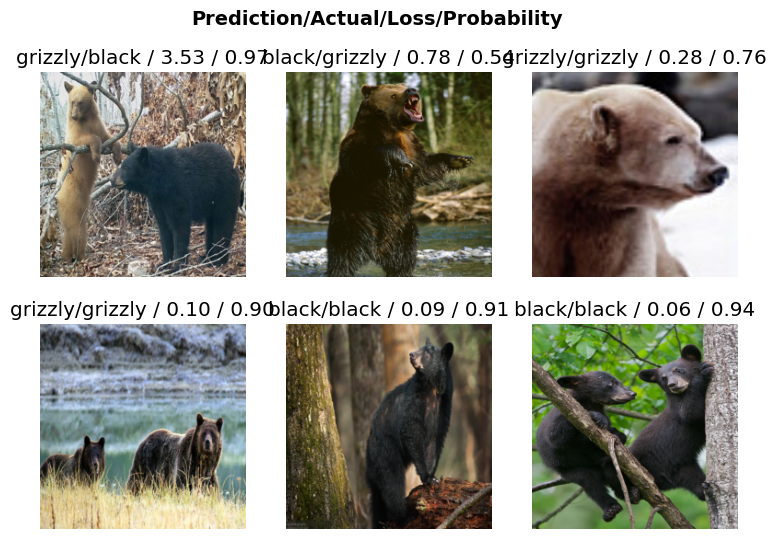

In [18]:
interp.plot_top_losses(6, nrows=2)

In [21]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [22]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)


In [24]:
# Let's retrain with the clean-up dataset
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.526101,0.333782,0.083333,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.207498,0.309262,0.055556,00:12
1,0.151233,0.372860,0.046296,00:12
2,0.126068,0.371632,0.046296,00:13
3,0.102804,0.362223,0.046296,00:12


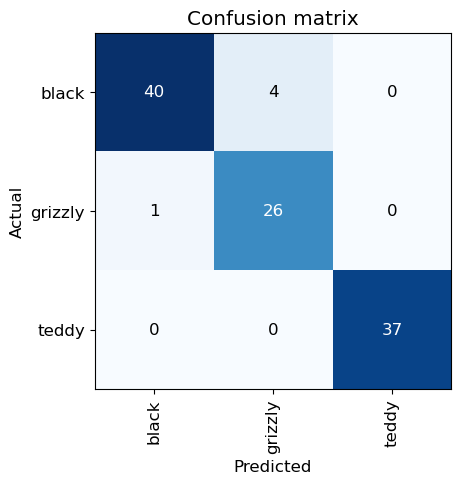

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

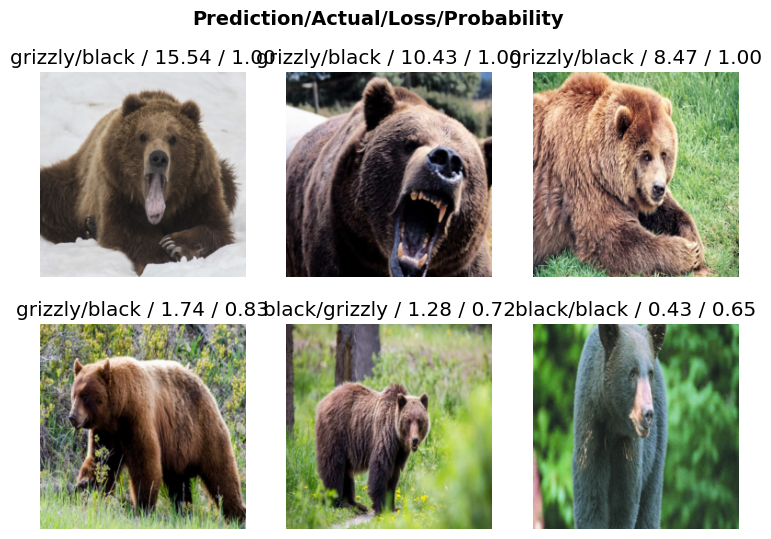

In [27]:
interp.plot_top_losses(6, nrows=2)

In [30]:
# Exporting the model
learn.export('bear_model.pkl')